<a href="https://colab.research.google.com/github/jejjohnson/gp_model_zoo/blob/master/code/numpyro/exact_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EGP (MCMC Schemes)

A demo notebook showing how solve a simple regression problem using an exact Gaussian Process (GP). This GP is trained with MLE and we will use the numpyro library as the backend for the inference.

In [1]:
# #@title Install Packages
# %%capture
# !pip install pyprojroot jax jaxlib chex numpyro flax distrax numpy pandas seaborn matplotlib corner loguru nb_black sklearn

In [2]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])

# append to path
sys.path.append(str(root))

In [3]:
# @title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# JAX SETTINGS
import jax
import jax.numpy as jnp
import jax.random as random
from jax.config import config

config.update("jax_enable_x64", True)


# JAX UTILITY LIBRARIES
import chex

# NUMPYRO SETTINGS
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, Trace_ELBO

# NUMPY SETTINGS
import numpy as np

np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns

sns.set_context(context="poster", font_scale=0.8)

# PANDAS SETTINGS
import pandas as pd

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import loguru

%load_ext lab_black
%load_ext autoreload
%autoreload 2

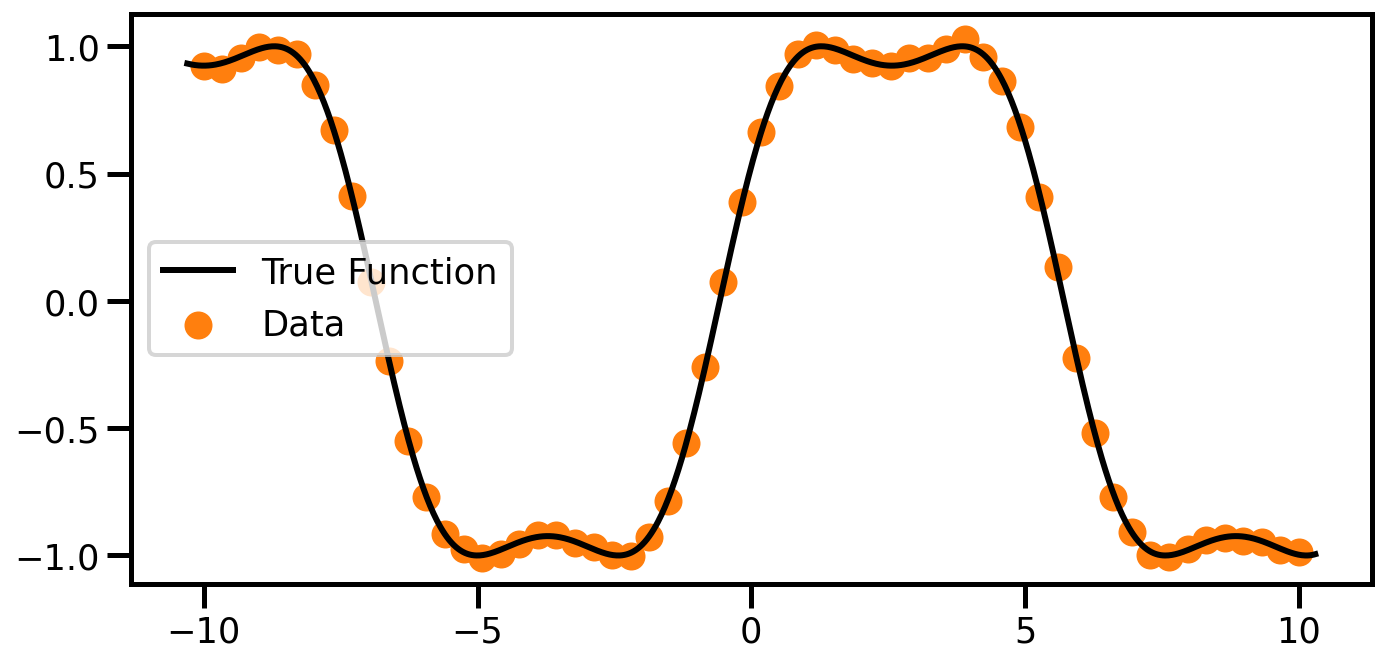

In [4]:
from src.data import regression_near_square

(
    Xtrain,
    Xtrain_noise,
    ytrain,
    xtest,
    xtest_noise,
    ytest,
    ytest_noise,
) = regression_near_square(
    n_train=60, n_test=1_000, x_noise=0.5, y_noise=0.01, seed=123, buffer=0.3
)

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(Xtrain, ytrain, color="tab:orange", label="Data")
ax.plot(xtest, ytest, color="black", label="True Function")
ax.legend()
plt.tight_layout()
plt.show()

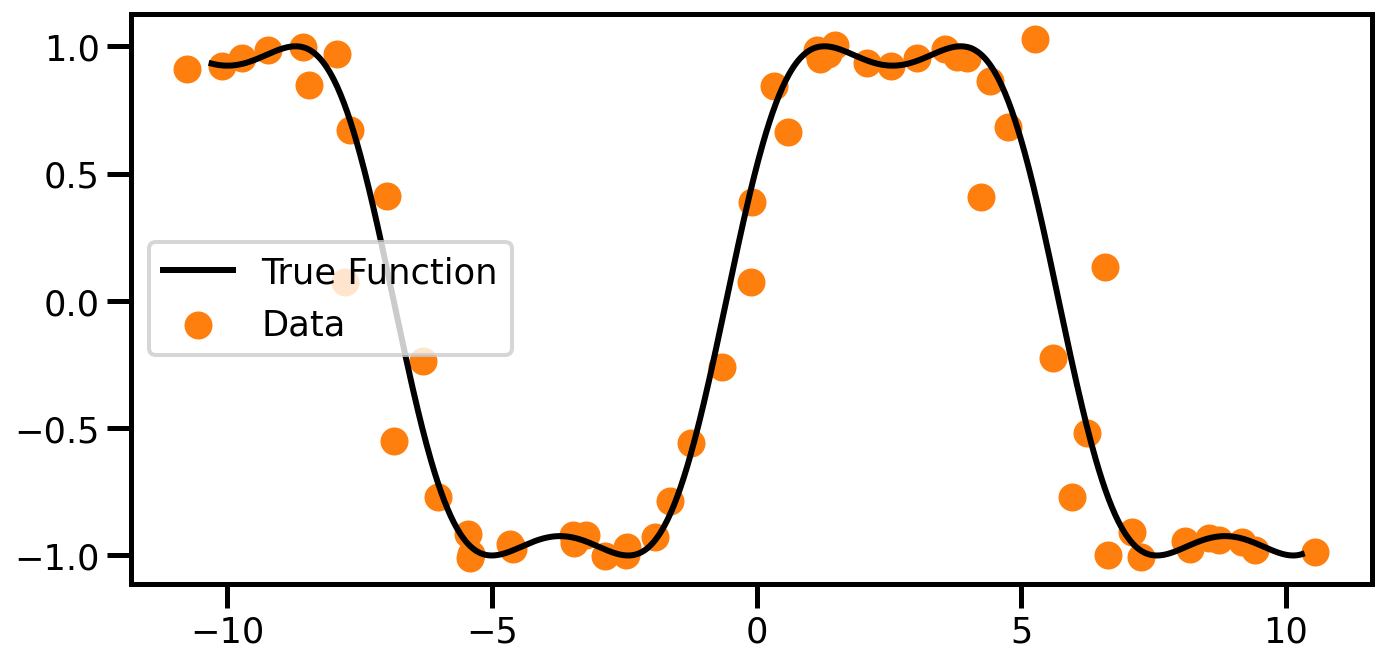

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(Xtrain_noise, ytrain, color="tab:orange", label="Data")
ax.plot(xtest, ytest, color="black", label="True Function")
ax.legend()
plt.tight_layout()
plt.show()

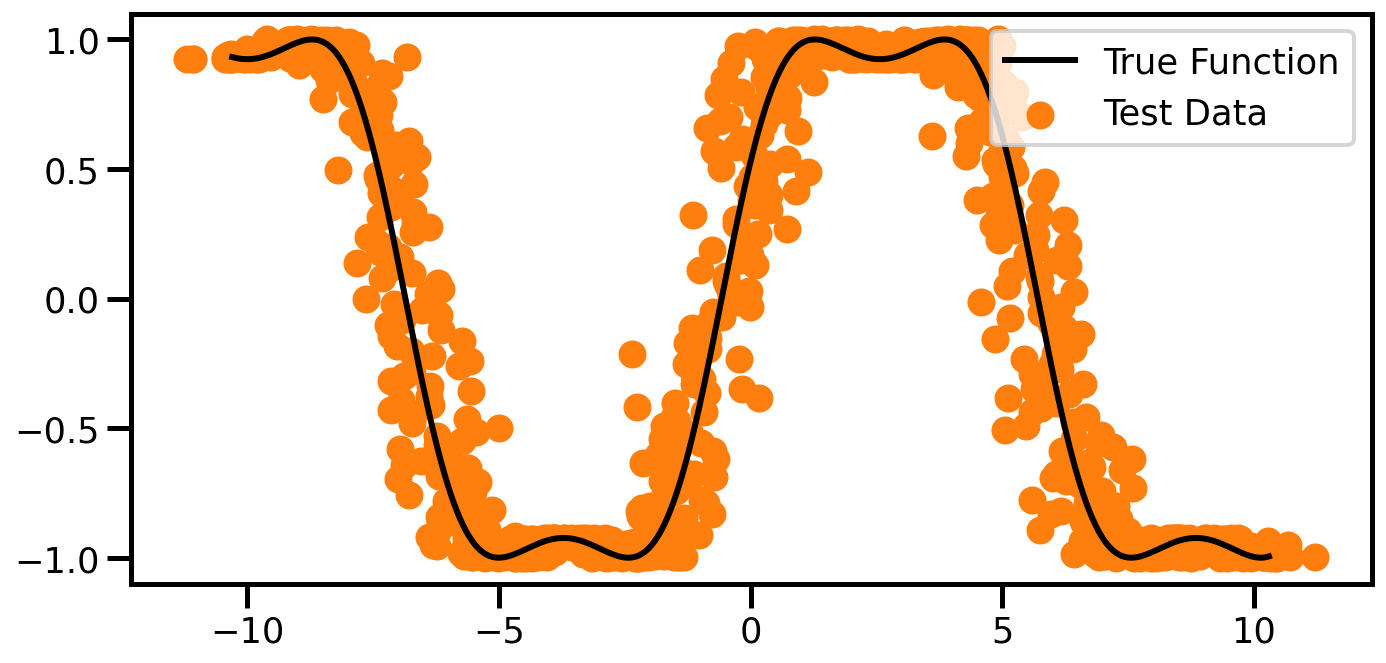

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(xtest_noise, ytest_noise, color="tab:orange", label="Test Data")
ax.plot(xtest, ytest, color="black", label="True Function")
ax.legend()
plt.tight_layout()
plt.show()

## Gaussian Process Model

#### Kernel

In [7]:
from chex import Array
from src.utils import identity_matrix, add_to_diagonal
from src.kernels import RBF

rbf_kernel = RBF(length_scale=1.0, variance=1.0)
K = rbf_kernel.gram(Xtrain)

# check shape
chex.assert_shape(K, (Xtrain.shape[0], Xtrain.shape[0]))

### Model

In [8]:
from src.exact import GPRModel
from src.means import zero_mean

jitter = 1e-5


def numpyro_model(X, y):

    #     # Set priors on hyperparameters.
    #     η = numpyro.sample("variance", dist.HalfCauchy(scale=5.0))
    #     ℓ = numpyro.sample("length_scale", dist.Gamma(2.0, 1.0))
    #     σ = numpyro.sample("obs_noise", dist.HalfCauchy(scale=5.0))

    # set params and constraints on hyperparams
    η = numpyro.param("variance", init_value=1.0, constraints=dist.constraints.positive)
    ℓ = numpyro.param(
        "length_scale", init_value=1.0, constraints=dist.constraints.positive
    )
    σ = numpyro.param(
        "obs_noise", init_value=0.01, onstraints=dist.constraints.positive
    )

    # Kernel Function
    rbf_kernel = RBF(variance=η, length_scale=ℓ)

    # GP Model
    gp_model = GPRModel(
        X=X, y=y, mean=zero_mean, kernel=rbf_kernel, obs_noise=σ, jitter=jitter
    )

    # Sample y according SGP
    return gp_model.to_numpyro(y=y)


def empty_guide(X, y):
    pass

In [9]:
with numpyro.handlers.seed(rng_seed=123):
    t = numpyro_model(Xtrain, ytrain)

assert t.shape == Xtrain.shape

## Training (Maximum Likelihood)

In [10]:
from numpyro.infer.autoguide import AutoDelta

# ===================
# Model
# ===================
# GP model

# delta guide - basically deterministic
delta_guide = AutoDelta(numpyro_model)
mll_guide = empty_guide

In [11]:
# reproducibility
rng_key = random.PRNGKey(0)


# Setup
optimizer = numpyro.optim.Adam(step_size=0.01)
# optimizer = numpyro.optim.Minimize()
# optimizer = optax.adamw(learning_rate=0.1)
svi = SVI(numpyro_model, mll_guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(random.PRNGKey(1), 100, Xtrain, ytrain.T)

100%|██████████| 100/100 [00:00<00:00, 122.40it/s, init loss: -23.6056, avg. loss [96-100]: -2.7395]


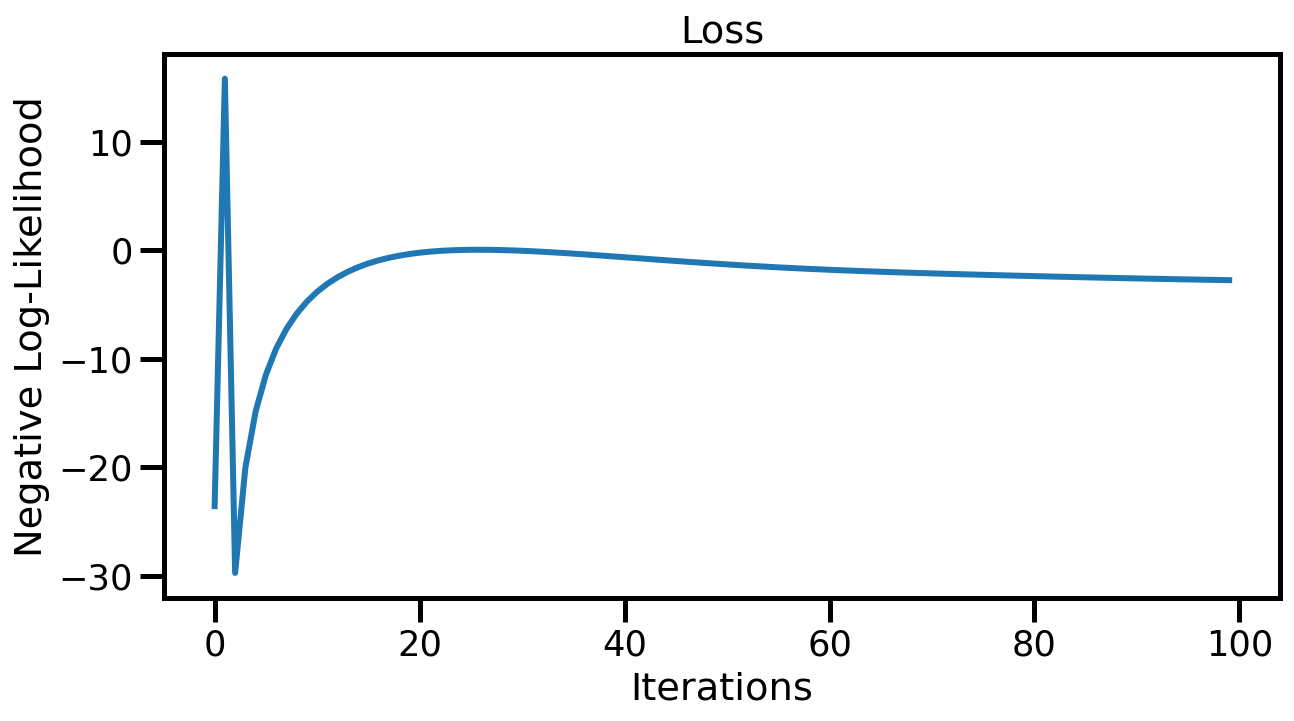

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(svi_results.losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.show()

### Extracting the Params

In [13]:
from pprint import pprint

# Take them directly
learned_params = svi_results.params
# x_u = learned_params["x_u"]
# learned_params = delta_guide.median(learned_params)
# learned_params["x_u"] = x_u

### Predictions

In [14]:
from src.exact import init_gp_predictive, get_cond_params

gp_pred = init_gp_predictive(RBF, learned_params, Xtrain, ytrain, jitter=1e-5)

mu, var = gp_pred.predict_y(xtest)

std = jnp.sqrt(var.squeeze())

In [15]:
ci = 1.96
one_stddev = ci * std

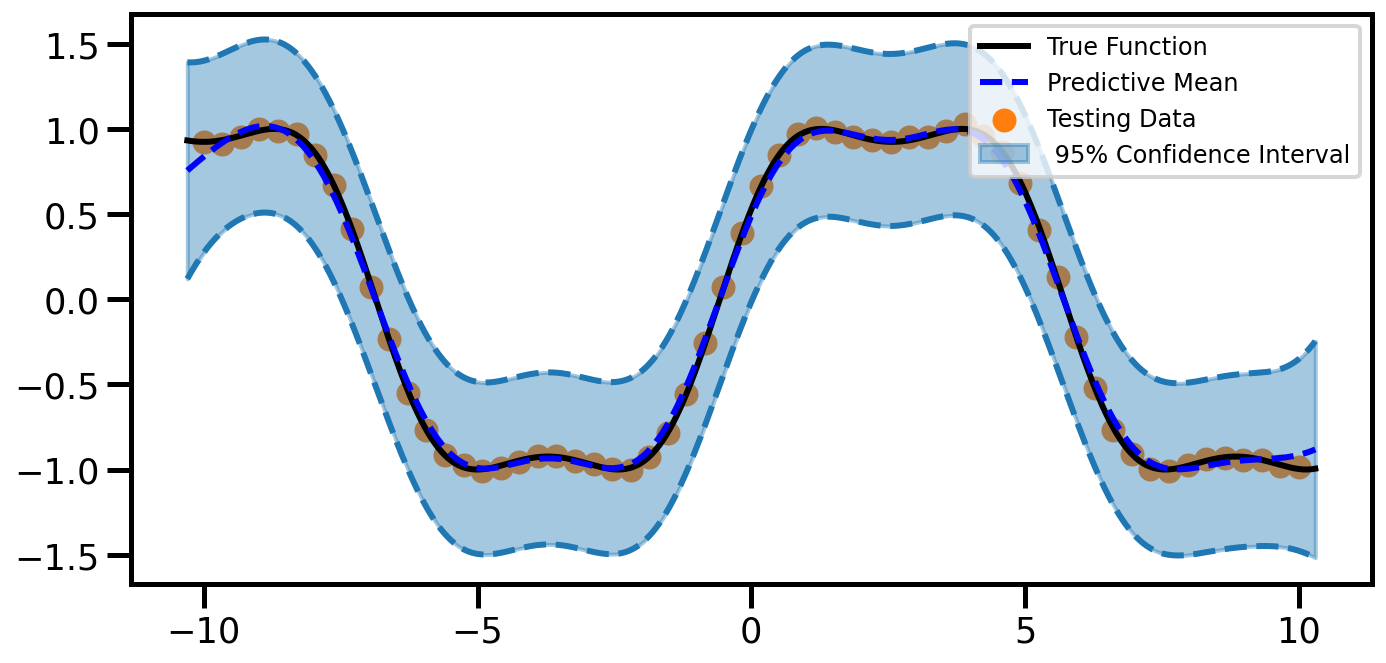

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(Xtrain, ytrain, marker="o", s=100, color="tab:orange", label="Testing Data")
ax.plot(xtest, ytest, color="black", linestyle="-", label="True Function")
ax.plot(
    xtest,
    mu.ravel(),
    color="Blue",
    linestyle="--",
    linewidth=3,
    label="Predictive Mean",
)
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
    label=f" 95% Confidence Interval",
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.tight_layout()
plt.legend(fontsize=12)
plt.show()

## Calibration

In [17]:
from uncertainty_toolbox import viz as utviz

#### Test Data

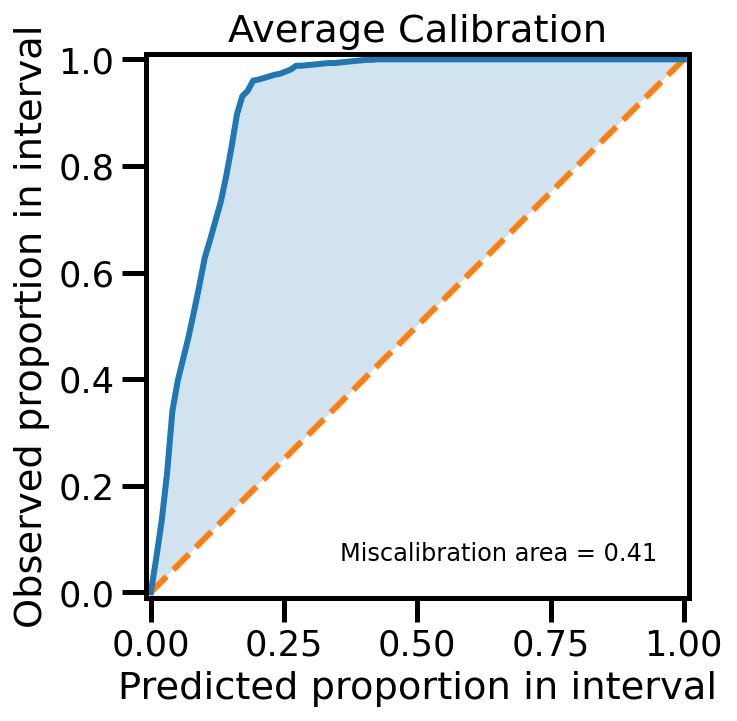

In [18]:
mu, var = gp_pred.predict_y(xtest)

std = jnp.sqrt(var.squeeze())

utviz.plot_calibration(y_pred=mu.ravel(), y_std=std.ravel(), y_true=ytest.ravel())

## Noisy Test Data

In [19]:
from src.exact import init_gp_predictive, get_cond_params

gp_pred = init_gp_predictive(RBF, learned_params, Xtrain, ytrain, jitter=1e-8)

mu, var = gp_pred.predict_y(xtest_noise)

std = jnp.sqrt(var.squeeze())

ci = 1.96
one_stddev = ci * std

In [20]:
idx_samples = np.random.choice(np.arange(xtest_noise.shape[0]), 50)

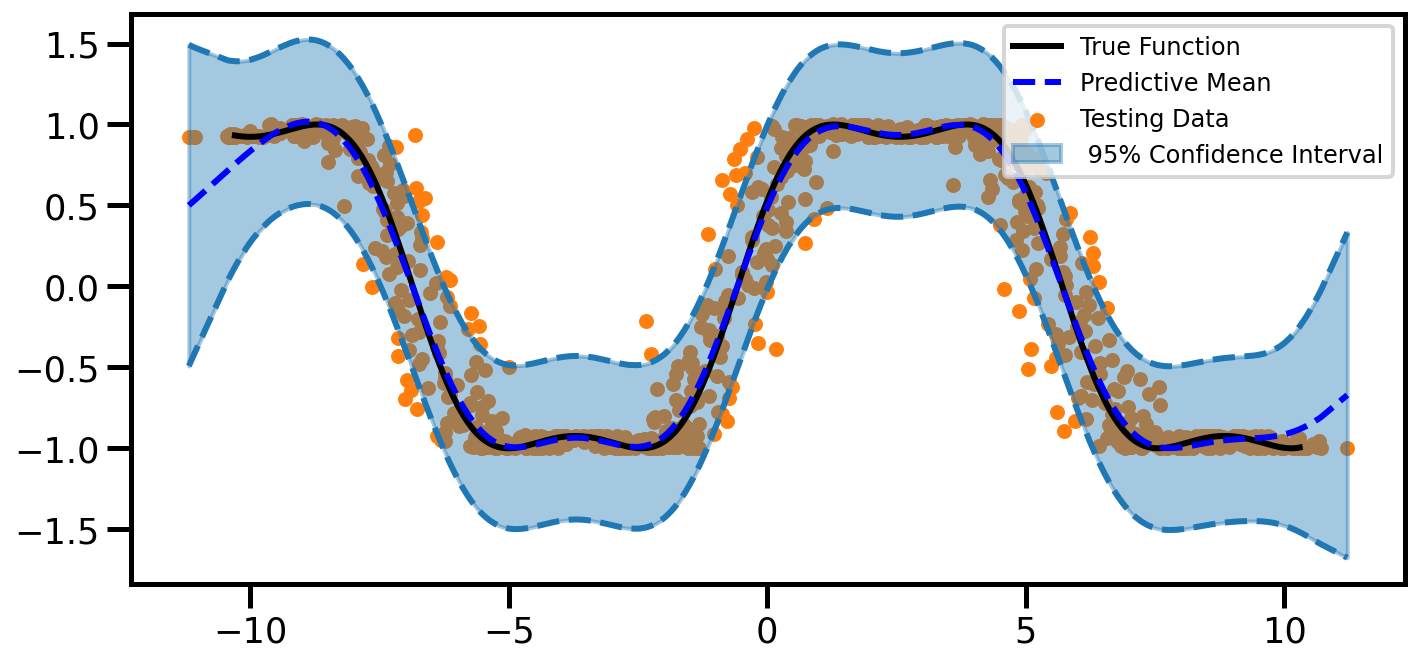

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(
    xtest_noise, ytest_noise, marker="o", s=30, color="tab:orange", label="Testing Data"
)
ax.plot(xtest, ytest, color="black", linestyle="-", label="True Function")
ax.plot(
    xtest_noise,
    mu.ravel(),
    color="Blue",
    linestyle="--",
    linewidth=3,
    label="Predictive Mean",
)
ax.fill_between(
    xtest_noise.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
    label=f" 95% Confidence Interval",
)
ax.plot(xtest_noise, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest_noise, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.tight_layout()
plt.legend(fontsize=12)
plt.show()

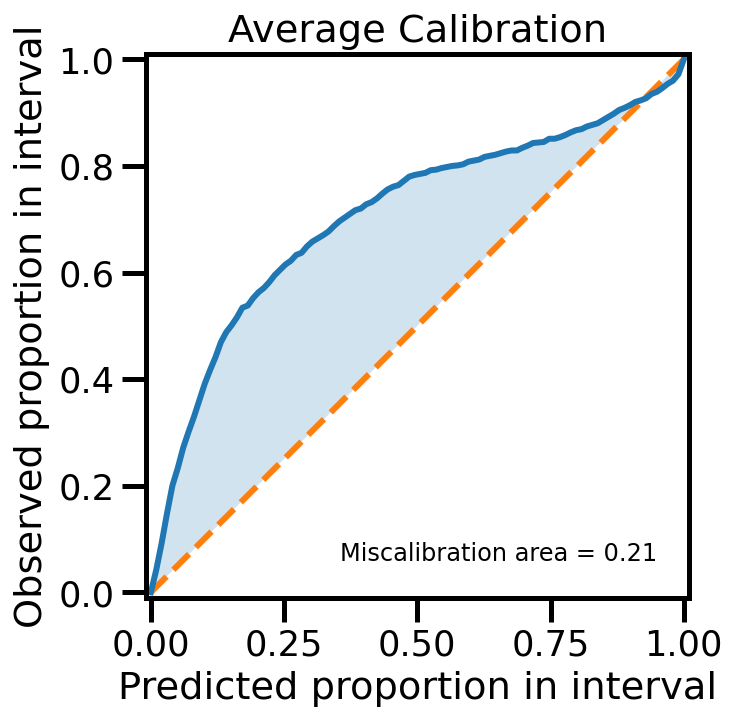

In [22]:
mu, var = gp_pred.predict_y(xtest_noise)

std = jnp.sqrt(var.squeeze())

utviz.plot_calibration(y_pred=mu.ravel(), y_std=std.ravel(), y_true=ytest_noise.ravel())

## Monte Carlo Samples

In this first example, we will approximate the actual posterior using Monte Carlo sampling. Using the following formula:

$$
p(f_*|\mu_\mathbf{x}, \Sigma_\mathbf{x}, \mathcal{D}) \approx \frac{1}{T}\sum_{t=1}^T \mathcal{N}\left(f_*|\mu_\mathcal{GP}(\mathbf{x}_*^t),\sigma^2_\mathcal{GP}(\mathbf{x}_*^t) \right) 
$$

This will approach the real posterior as $T$ grows. What we want to demonstrate is that this posterior is non-Gaussian when our inputs are non-Gaussian.

In this example, we assume that $\mathbf{x}_* \sim \mathcal{N}(\mathbf{\mu_x}, \mathbf{\Sigma_x})$. We're assuming our data points come We can reparameterize this as f


we will be using the following form to do the sampling:

$$
\mathbf{x}_T = \mu_\mathbf{x} + \mathbf{L}\mathbf{z}
$$

where $\mathbf{z}\sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. So we will draw 10,000 samples and then propagate all of these through the non-linear function.

In [23]:
from src.uncertain.monte_carlo import init_mc_transform


egp_pred_mc = init_mc_transform(gp_pred, n_features=1, n_samples=1_000)
x_cov = jnp.array([0.5]).reshape(-1, 1) ** 2
key = jax.random.PRNGKey(123)

mu_mc, var_mc = egp_pred_mc.predict_f(key, xtest_noise, x_cov, False)
std_mc = jnp.sqrt(var_mc).ravel()
mu_mc.shape, std_mc.shape

((1000, 1), (1000,))

In [24]:
ci = 1.96
one_stddev = ci * std_mc

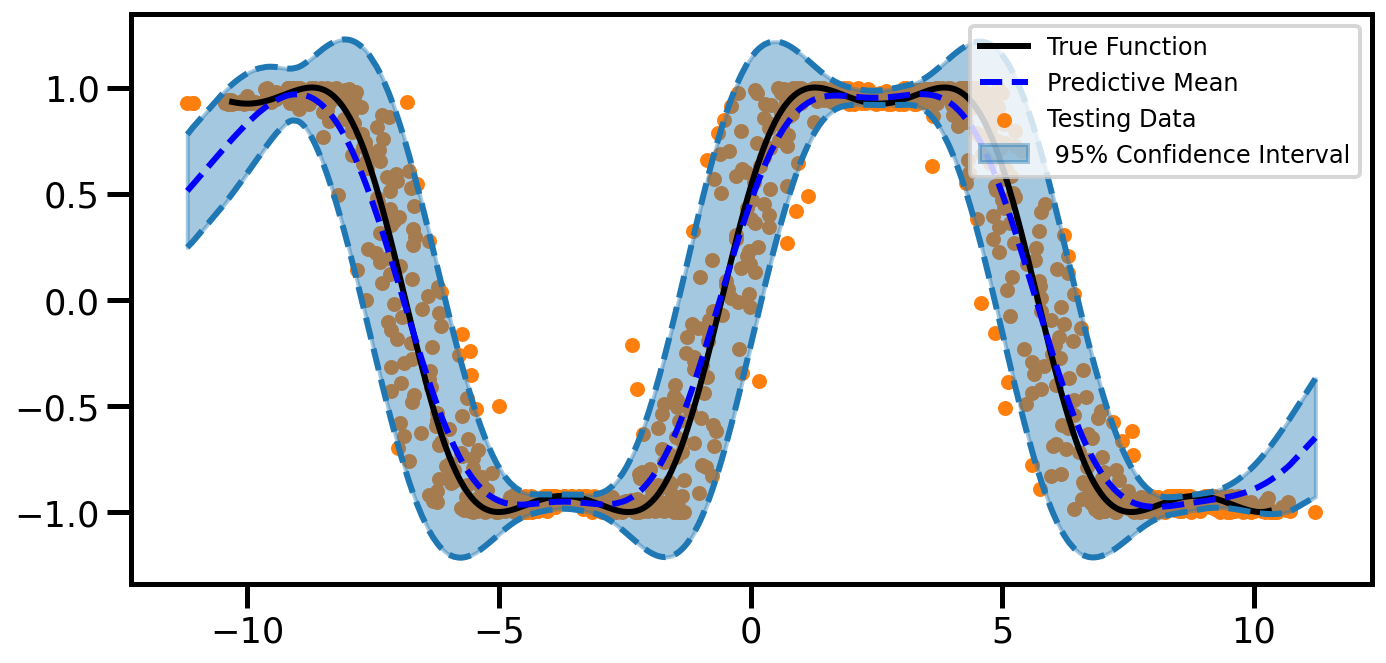

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(
    xtest_noise, ytest_noise, marker="o", s=30, color="tab:orange", label="Testing Data"
)
ax.plot(xtest, ytest, color="black", linestyle="-", label="True Function")
ax.plot(
    xtest_noise,
    mu_mc.ravel(),
    color="Blue",
    linestyle="--",
    linewidth=3,
    label="Predictive Mean",
)
ax.fill_between(
    xtest_noise.ravel(),
    mu_mc.ravel() - one_stddev,
    mu_mc.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
    label=f" 95% Confidence Interval",
)
ax.plot(xtest_noise, mu_mc.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest_noise, mu_mc.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.tight_layout()
plt.legend(fontsize=12)
plt.show()

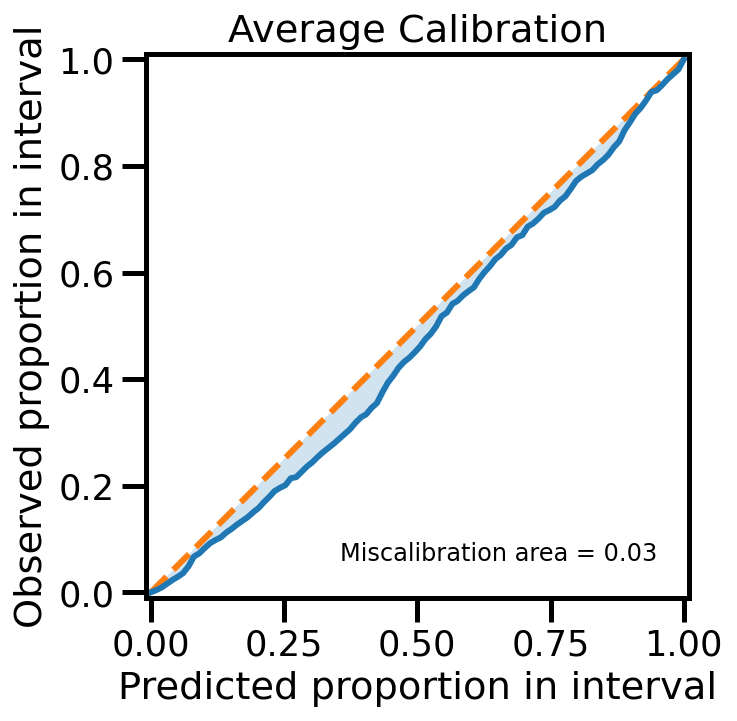

In [26]:
utviz.plot_calibration(
    y_pred=mu_mc.ravel(), y_std=std_mc.ravel(), y_true=ytest_noise.ravel()
)

## Sigma Points

### Unscented Transformation

In [27]:
from src.uncertain.unscented import init_unscented_transform


egp_pred_unc = init_unscented_transform(gp_pred, n_features=1)
x_cov = jnp.array([0.5]).reshape(-1, 1) ** 2
key = jax.random.PRNGKey(123)

mu_unc, var_unc = egp_pred_unc.predict_f(xtest_noise, x_cov, False)
std_unc = jnp.sqrt(var_unc.squeeze())

In [28]:
ci = 1.96
one_stddev = ci * std_unc

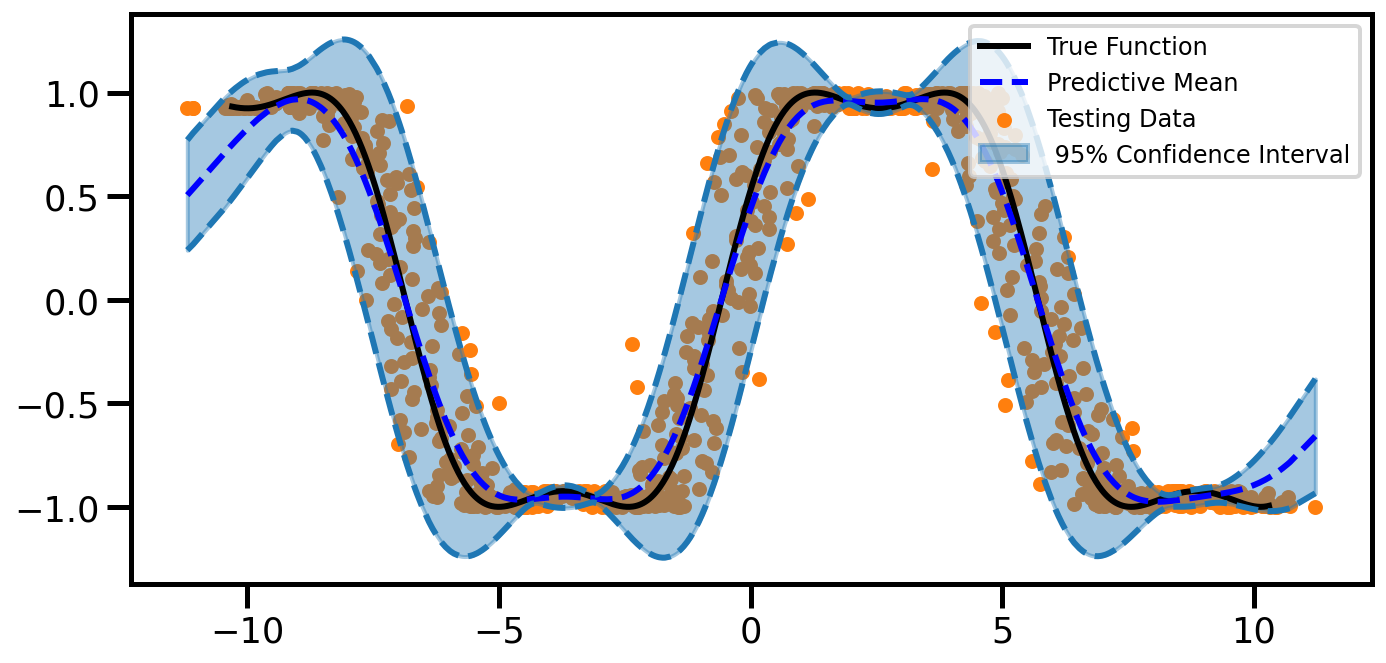

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(
    xtest_noise, ytest_noise, marker="o", s=30, color="tab:orange", label="Testing Data"
)
ax.plot(xtest, ytest, color="black", linestyle="-", label="True Function")
ax.plot(
    xtest_noise,
    mu_unc.ravel(),
    color="Blue",
    linestyle="--",
    linewidth=3,
    label="Predictive Mean",
)
ax.fill_between(
    xtest_noise.ravel(),
    mu_unc.ravel() - one_stddev,
    mu_unc.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
    label=f" 95% Confidence Interval",
)
ax.plot(xtest_noise, mu_unc.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest_noise, mu_unc.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.tight_layout()
plt.legend(fontsize=12)
plt.show()

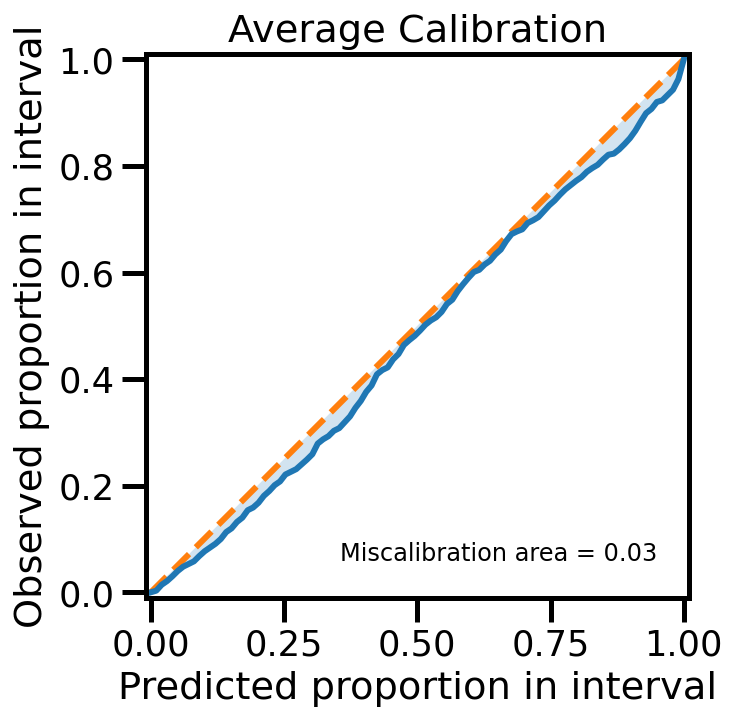

In [30]:
utviz.plot_calibration(
    y_pred=mu_unc.ravel(), y_std=std_unc.ravel(), y_true=ytest_noise.ravel()
)